## ONLINE RETAIL COMPUTER VISION MODEL 

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim 
import torch.backends.cudnn as cudnn
import numpy as np 
import torchvision 
from torchvision import models, transforms 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import time 
import os 
from PIL import Image 
from tempfile import TemporaryDirectory 


cudnn.benchmark = True 
plt.ion()

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Ensure 3 values per list
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Ensure 3 values per list
    ])
}


In [5]:
import os
from PIL import Image

data = pd.read_csv(r"C:\Users\nexwa\OneDrive\Desktop\DATA SCIENCE PROJECTS\PYTHON PROJECTS\RETAIL PRODUCTS DATASET.csv")
# Extract paths from the correct columns
image_paths = data.iloc[:, 1:4].values.flatten()  # Flatten to get a 1D array of paths
image_paths = [str(path).strip() for path in image_paths]  

# Remove any NaN values 
image_paths = [path for path in image_paths if path and path.lower() != "nan"]

# Open images
images = [Image.open(image_path) for image_path in image_paths]




In [6]:
from sklearn.preprocessing import LabelEncoder
image_labels = data.iloc[:, 0].values.flatten()
encoder = LabelEncoder()
image_labels = encoder.fit_transform(image_labels)
image_labels

array([0, 1, 2, 3, 4, 5, 6])

In [7]:
# Convert RGBA images to RGB before applying transforms
images = [image.convert("RGB") for image in images]

# Apply transformations
transformed_images = [data_transforms['train'](image) for image in images]

# Convert to tensor batch
image_batch = torch.stack(transformed_images)

print(f"Transformed batch shape: {image_batch.shape}") 


Transformed batch shape: torch.Size([21, 3, 224, 224])


In [10]:
# Extract labels for all images, not just unique products
image_labels = data.iloc[:, 0].repeat(3).values  # Repeat labels based on images per row
encoder = LabelEncoder()
image_labels = encoder.fit_transform(image_labels)

# Convert to tensor
image_labels_tensor = torch.tensor(image_labels, dtype=torch.long)

# Verify sizes
print(f"Image batch shape: {image_batch.shape}")  
print(f"Labels shape: {image_labels_tensor.shape}")  

# Ensure sizes match
if image_batch.shape[0] == image_labels_tensor.shape[0]:
    dataset = TensorDataset(image_batch, image_labels_tensor)
    batch_size = 8
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    dataset_size = len(dataset)
    print(f"Dataset size: {dataset_size}")
else:
    print(f"Size mismatch: {image_batch.shape[0]} images vs {image_labels_tensor.shape[0]} labels")


Image batch shape: torch.Size([21, 3, 224, 224])
Labels shape: torch.Size([21])
Dataset size: 21


In [11]:
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for images, labels in dataloader:
    print(f"Batch image shape: {images.shape}")
    print(f"Batch label shape: {labels.shape}")
    break  # Only print the first batch


Batch image shape: torch.Size([8, 3, 224, 224])
Batch label shape: torch.Size([8])


In [12]:
dataset_size = len(dataset)
class_names = encoder.classes_
print(f"Dataset size: {dataset_size}")
print(f"Class names: {class_names}")


Dataset size: 21
Class names: ['CHAIN TWO SOY SAUCE' 'FRESH FRI COOKING OIL' 'KEN SALT' 'KNORR CUBES'
 'RINA COOKING OIL' 'ROYCO CUBES' 'ROYCO MCHUZI MIX']


In [13]:
from torch.utils.data import random_split

# Assuming dataset is already defined as TensorDataset
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Verify split sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Training dataset size: 16
Validation dataset size: 5


In [14]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


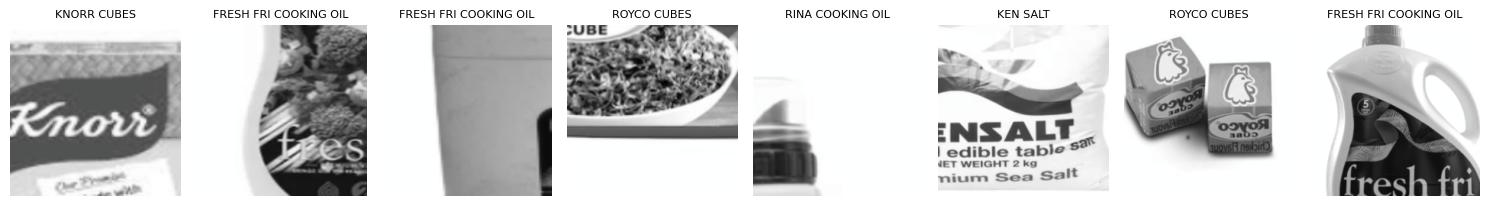

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display an image
def imshow(img, ax):
    img = img.numpy().transpose((1, 2, 0))  
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean 
    img = np.clip(img, 0, 1)  
    ax.imshow(img)
    ax.axis("off")

# Get a batch of images
images, labels = next(iter(dataloader))

# Create subplots to display multiple images
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))  

for i in range(len(images)):
    imshow(images[i], axes[i])
    axes[i].set_title(class_names[labels[i].item()], fontsize=8)

plt.tight_layout()
plt.show()


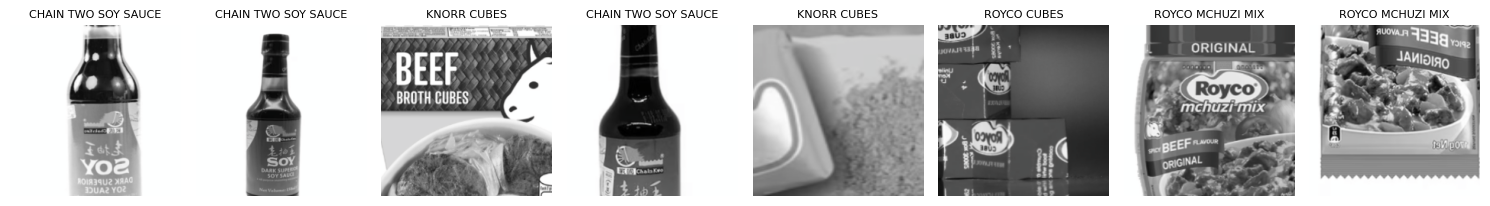

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display an image
def imshow(img, ax):
    img = img.numpy().transpose((1, 2, 0))  # Convert tensor to numpy image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = img * std + mean  
    img = np.clip(img, 0, 1) 
    ax.imshow(img)
    ax.axis("off")

# Get a batch of images and labels
images, labels = next(iter(dataloader))

# Create subplots for visualization
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

for i in range(len(images)):
    imshow(images[i], axes[i])  
    axes[i].set_title(class_names[labels[i].item()], fontsize=8)

plt.tight_layout()
plt.show()


In [16]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

**MODEL TRAINING**

In [95]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer for your number of classes
num_classes = len(encoder.classes_)  #
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to CPU
model = model.to('cpu')


c:\Users\nexwa\anaconda3\envs\DataScience\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nexwa\anaconda3\envs\DataScience\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\nexwa/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:10<00:00, 4.50MB/s]


In [96]:
# Loss function
criterion = nn.CrossEntropyLoss()


In [97]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [104]:
# Number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        # Move data to CPU (for consistency)
        inputs, labels = inputs.to('cpu'), labels.to('cpu')
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass (gradient computation)
        loss.backward()
        
        # Update the model weights
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
    
    # Calculate average loss and accuracy for this epoch
    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct_preds / total_preds
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/10], Loss: 0.0013, Accuracy: 100.00%
Epoch [2/10], Loss: 0.0036, Accuracy: 100.00%
Epoch [3/10], Loss: 0.0184, Accuracy: 100.00%
Epoch [4/10], Loss: 0.0763, Accuracy: 87.50%
Epoch [5/10], Loss: 0.0033, Accuracy: 100.00%
Epoch [6/10], Loss: 0.0089, Accuracy: 100.00%
Epoch [7/10], Loss: 0.1227, Accuracy: 87.50%
Epoch [8/10], Loss: 0.1328, Accuracy: 93.75%
Epoch [9/10], Loss: 0.0642, Accuracy: 93.75%
Epoch [10/10], Loss: 0.0110, Accuracy: 100.00%


In [105]:
# Switch the model to evaluation mode
model.eval()

# Inference phase (No gradient calculation)
with torch.no_grad():
    correct_preds = 0
    total_preds = 0

    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to('cpu'), labels.to('cpu')
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
    
    accuracy = 100 * correct_preds / total_preds
    print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 100.00%


The Model seems to either overfit or there is data leakage. We have to perfom cross validation or determine whether we have a leakage

Perfom cross validation to test whether the model is overfitting 

In [ ]:
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Parameters
k = 5  
batch_size = 8
num_epochs = 5  
# KFold Cross Validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# To store results
fold_accuracies = []

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(image_batch)):
    print(f"Training fold {fold + 1}/{k}...")
    
    # Split data for this fold
    train_images, val_images = image_batch[train_idx], image_batch[val_idx]
    train_labels, val_labels = image_labels_tensor[train_idx], image_labels_tensor[val_idx]
    
    # Create DataLoader for this fold
    train_dataset = TensorDataset(train_images, train_labels)
    val_dataset = TensorDataset(val_images, val_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize the model 
    model = model  
    
    # Set up the loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            # Move data to the device (CPU or CUDA)
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

    # Evaluation
    model.eval()
    val_preds = []
    val_labels_list = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    # Compute accuracy
    accuracy = accuracy_score(val_labels_list, val_preds)
    fold_accuracies.append(accuracy)
    print(f"Fold {fold + 1} Validation Accuracy: {accuracy:.4f}")

# Average accuracy across all folds
average_accuracy = sum(fold_accuracies) / k
print(f"Average Cross-Validation Accuracy: {average_accuracy:.4f}")


Training fold 1/5...
Fold 1, Epoch 1, Loss: 0.4800429046154022
Fold 1, Epoch 2, Loss: 0.10256681591272354
Fold 1, Epoch 3, Loss: 0.2245866283774376
Fold 1, Epoch 4, Loss: 0.13224774971604347
Fold 1, Epoch 5, Loss: 0.009298461955040693
Fold 1 Validation Accuracy: 1.0000
Training fold 2/5...
Fold 2, Epoch 1, Loss: 1.3202521732697885
Fold 2, Epoch 2, Loss: 1.214475651582082
Fold 2, Epoch 3, Loss: 1.5711792210737865
Fold 2, Epoch 4, Loss: 0.8577314789096514
Fold 2, Epoch 5, Loss: 0.41998813798030216
Fold 2 Validation Accuracy: 1.0000
Training fold 3/5...
Fold 3, Epoch 1, Loss: 0.7953922798236212
Fold 3, Epoch 2, Loss: 0.6531687236080567
Fold 3, Epoch 3, Loss: 1.090632239356637
Fold 3, Epoch 4, Loss: 0.2656343577740093
Fold 3, Epoch 5, Loss: 0.651521285995841
Fold 3 Validation Accuracy: 0.5000
Training fold 4/5...
Fold 4, Epoch 1, Loss: 1.7359724687412381
Fold 4, Epoch 2, Loss: 1.0635834435621898
Fold 4, Epoch 3, Loss: 0.6540928979714712
Fold 4, Epoch 4, Loss: 0.5871126838028431
Fold 4, Epo

**MODEL SAVING AND DEPLOYMENT**

In [111]:
# Save the trained model
torch.save(model.state_dict(), 'Online_retail_comp_vision_resnet18_model.pth')
print("Model saved successfully.")


Model saved successfully.


In [112]:
# Initialize the model again
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer
num_classes = len(encoder.classes_)  # This should match the number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the saved model weights
model.load_state_dict(torch.load('Online_retail_comp_vision_resnet18_model.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully.")


c:\Users\nexwa\anaconda3\envs\DataScience\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nexwa\anaconda3\envs\DataScience\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully.


In [113]:
from PIL import Image
import torch
from torchvision import transforms

# Define the same transformations for inference (resize, crop, normalize)
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.485, 0.406], [0.229, 0.224, 0.225])  # Mean and Std used in ResNet
])

def predict_image(image_path):
    # Open the image file
    image = Image.open(image_path)
    
    # Apply transformations
    image = data_transforms(image).unsqueeze(0)  # Add batch dimension

    # Move image to the same device as the model (CPU in this case)
    image = image.to('cpu')
    
    # Predict
    with torch.no_grad():
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)
    
    # Convert prediction to class label
    predicted_label = encoder.inverse_transform([predicted_class.item()])[0]
    
    return predicted_label

**MODEL PREDICTIONS**

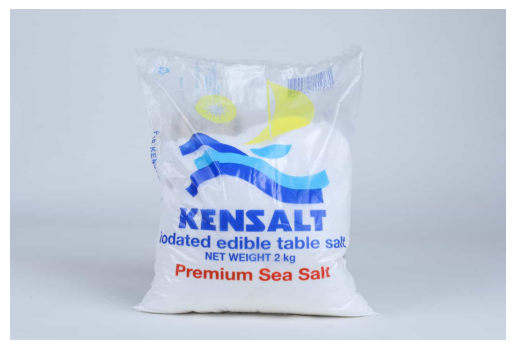

THE PROUCT ABOVE IS: KEN SALT


In [126]:
def predict(path):

    # Example usage:
    image = Image.open(path)

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # To hide the axis labels
    plt.show()
    #predict
    predicted_label = predict_image(image_path)
    print(f"THE PROUCT ABOVE IS: {predicted_label}")

    
image_path = r"C:\Users\nexwa\Downloads\Greenspoon-Kensalt-2Kg-1.jpg"
predict(image_path)

### Model Performance Report: Product Classification

**Objective**:  
The objective of this model is to classify images of various products using a Convolutional Neural Network (CNN). The model was trained to recognize multiple products, and **Ken Salt** was used as an example during testing.

**Training Process**:  
The model was trained on a dataset containing images of different products and was optimized for multi-class classification. Data augmentation and standard preprocessing steps were applied to improve the model's robustness and ability to generalize across diverse product images.

**Cross-Validation Results**:  

- **Fold 1**: The model achieved **100%** validation accuracy, indicating excellent performance on this fold.  
- **Fold 2**: Another **100%** validation accuracy, demonstrating consistency in predictions across this subset of the data.  
- **Fold 3**: The model's performance dropped to **50%** accuracy, suggesting it faced challenges with certain images in this fold.  
- **Fold 4**: Similar to fold 3, **50%** accuracy was achieved, indicating areas for improvement in generalizing across the dataset.  
- **Fold 5**: The model performed at **100%** validation accuracy again, reinforcing its ability to classify certain product images correctly.

The **average cross-validation accuracy** across all folds was **80%**, indicating strong overall performance, but also highlighting the need for further refinement, especially in folds with lower accuracy.

**Conclusion**:  
Our CNN-based model has shown promising results in classifying a range of products with an **average accuracy of 80%**. While the model demonstrates high performance on some subsets of the data, there is room for improvement, particularly for cases where it struggles to generalize (e.g., folds 3 and 4).

To further improve performance, techniques such as additional data augmentation, fine-tuning the model's hyperparameters, and expanding the training dataset could be beneficial. Despite some variability in performance, the model holds great potential for product classification tasks, with further optimizations required to ensure reliable real-world application especially in online retail businesses.